In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate2d, convolve2d # scipy.signal is a signal processing library

# The MNIST dataset 

The goal is to build a neural network to recognize handwritten digits.
We'll use the MNIST dataset.

**Contents:**
- [Neural Network Stuff](#Neural-Network-Stuff)
- [The training and testing MNIST datasets](#The-training-and-testing-MNIST-datasets)
- [Two-layer Neural Network](#Two-layer-Neural-Network)
- [Three-layer Neural Network](#Three-layer-Neural-Network)

## Neural Network Stuff

In [2]:
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        

        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs)
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
        
        
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

## The training and testing MNIST datasets

In [21]:
# load the training dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/digits.csv'
data_train = pd.read_csv(url)

# feature matrix X - target vector y
X = data_train.iloc[:,0:784].to_numpy() # pixels
y = data_train['label'].to_numpy() # labels
X 
X.shape,y.shape

((5000, 784), (5000,))

In [22]:
X_plot=X.reshape(len(X),1,28,28)


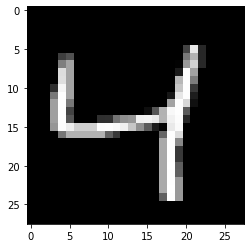

In [23]:
plt.imshow(X_plot[2,0],cmap='gray')

In [24]:
X[1].shape

(784,)

In [25]:
# load the testing dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/digits_test.csv'
data_test = pd.read_csv(url)

# feature matrix X - target vector y
X_test = data_test.iloc[:,0:784].to_numpy() # pixels
y_test = data_test['label'].to_numpy() # labels

In [26]:
#X_test=X_test.reshape(len(X_test),-1)


## Two-layer Neural Network

**Part 1:** Fit a neural network with two layers to the training dataset

In [27]:
# build the neural network 
# layer 1
layer1 = layer(n_inputs = 784, n_neurons = 784*4)
activation1 = ReLU()

# layer 2
layer2 = layer(n_inputs = 784*4, n_neurons = 784)
activation2 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)


In [28]:
n_epochs = 10
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):

    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)

    # loss (mean squared error)
    losses = loss_function.forward(activation2.output,y)
    loss_adam[epoch] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy_adam[epoch] = 100*np.mean(y_pred == y)

    # backward pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
#     optimizer.update_parameters(layer2)
    optimizer.post_update_parameters()

    
    
    # print loss and accuracy
    # loss
    loss = np.round(np.mean(losses),3)
    # accuracy (percentage of correct classifications)
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy = np.round(100*np.mean(y==y_pred),3)
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss_adam[epoch],3)))
    print('accuracy: '+str(accuracy_adam[epoch]))
    print('------------------------')

epoch: 0
loss: 12.864
accuracy: 0.0
------------------------
epoch: 1
loss: 2.543
accuracy: 62.63999999999999
------------------------
epoch: 2
loss: 4.094
accuracy: 59.199999999999996
------------------------
epoch: 3
loss: 3.334
accuracy: 68.58
------------------------
epoch: 4
loss: 2.222
accuracy: 76.8
------------------------
epoch: 5
loss: 1.243
accuracy: 85.48
------------------------
epoch: 6
loss: 1.22
accuracy: 85.58
------------------------
epoch: 7
loss: 1.213
accuracy: 86.02
------------------------
epoch: 8
loss: 1.243
accuracy: 86.88
------------------------
epoch: 9
loss: 1.244
accuracy: 86.08
------------------------


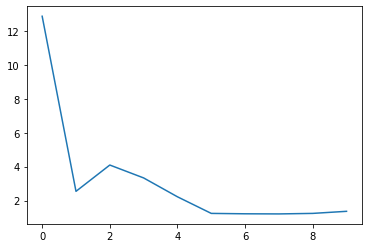

In [39]:
# plot the loss as a function of the number of epochs
plt.plot(loss_adam)

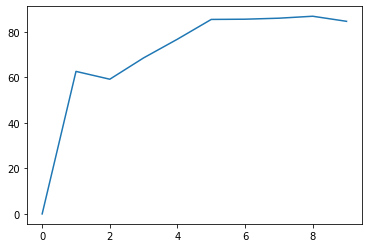

In [40]:
# plot the accuracy as a function of the number of epochs
plt.plot(accuracy_adam)

**Part 2:** Test your neural network on the test set.
Compute the accuracy and the confusion matrix.

In [41]:

# forward pass
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# loss (mean squared error)
losses = loss_function.forward(activation2.output,y_test)
loss_adam[epoch] = np.mean(losses)

# accuracy
y_test_pred = np.argmax(activation2.output,axis=1)
accuracy_adam[epoch] = 100*np.mean(y_test_pred == y_test)

In [42]:
# predictions
y_test_pred

array([8, 7, 9, ..., 8, 3, 7], dtype=int64)

In [43]:
# accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy=accuracy_score(y_test,y_test_pred)
accuracy

0.8465

In [44]:
# confusion matrix
confusion=confusion_matrix(y_test,y_test_pred)
confusion

array([[195,   0,   4,   2,   0,   0,   3,   0,   0,   1],
       [  0, 204,   9,   8,   1,   0,   2,   0,   0,   0],
       [  4,   0, 165,   9,   0,   0,   5,   0,   2,   0],
       [  7,   0,   9, 171,   0,   3,   1,   1,   3,   0],
       [  5,   1,   1,   3, 175,   2,   5,   0,   1,  11],
       [ 23,   0,   0,   5,   0, 151,   2,   2,   1,   1],
       [ 13,   0,   3,   1,   0,   3, 174,   0,   0,   0],
       [  7,   0,   2,  25,   1,   0,   0, 161,   1,  13],
       [  9,   2,   3,  29,   0,   8,   1,   0, 127,   4],
       [  3,   1,   2,  25,   5,   4,   0,   4,   1, 170]], dtype=int64)

**Part 3:** Display some of the misclassified digits.

## Three-layer Neural Network

In [50]:
class convolutional_layer():
    def __init__(self, input_shape, kernel_size, depth):
        
        # input_shape = (depth, width, height) of each input
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.input_depth = input_depth
        
        
        # depth = number of kernels
        self.depth = depth
        
        # output shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        
        # initialize kernels (weights) and biases
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.weights = 0.1*np.random.randn(depth, input_depth, kernel_size, kernel_size)
        self.biases = np.zeros(self.output_shape)

        # initialize momentums and caches (for ADAM)
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    def forward(self, inputs):
        
        # save inputs
        self.inputs = inputs
        
        # initialize output array
        self.output = np.copy(self.biases)
        
        # loop over kernels
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += correlate2d(self.inputs[j], self.weights[i, j], "valid")
                
    def backward(self, dinputs):

        # initialize gradients
        self.dweights = np.zeros(self.kernels_shape) # weights = kernels Kij
        self.dinputs = np.zeros(self.input_shape)
        self.dbiases = dinputs
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.dweights[i, j] = correlate2d(self.inputs[j], dinputs[i], "valid")
                self.dinputs[j] += convolve2d(dinputs[i], self.weights[i, j], "full")

    
    
    
class reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs):
        self.output = np.reshape(inputs, self.output_shape)

    def backward(self, dinputs):
        self.dinputs = np.reshape(dinputs, self.input_shape)
        
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        

        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
        
        
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

**Part 1:** Fit a neural network with three layers to the training dataset

In [53]:
X = X.reshape(len(X),1,28,28)

In [54]:
# layer 1
layer1 = convolutional_layer(input_shape=(1,28,28), kernel_size=3, depth=5)
activation1 = ReLU()

# layer 2
layer2 = reshape(input_shape=(5,26,26), output_shape=(1,5*26*26)) # 26 = 28-3+1

# layer 3
layer3 = layer(n_inputs = 5 * 26 * 26, n_neurons = 10)
activation3 = softmax()


# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.01)

In [55]:
# warning: CNNs on CPUs are very slow. To speed it up, we need to run this on GPUs
n_epochs = 10
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X))
    y_pred = np.zeros(len(X))
    for i in range(len(X)):

        # forward pass
        layer1.forward(X[i])
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)
        
        layer3.forward(layer2.output)
        activation3.forward(layer3.output)
        

        # sample loss
        losses[i] = loss_function.forward(activation3.output,y[i].reshape(1))
        # prediction
        y_pred[i] = np.argmax(activation3.output,axis=1)
        

        # backward pass
        loss_function.backward(activation3.output,y[i].reshape(1))
        activation3.backward(loss_function.dinputs)
        layer3.backward(activation3.dinputs)


        layer2.backward(layer3.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)


        # update weights and biases
        optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer3)
        optimizer.post_update_parameters()

    # loss and accuracy
    loss[epoch] = np.mean(losses)
    accuracy[epoch] = 100*np.mean(y_pred == y)
    
    
    # print loss and accuracy (every 100 epochs)
    print('epoch: '+str(epoch))
    print('loss: '+str(np.round(loss[epoch],3)))
    print('accuracy: '+str(accuracy[epoch]))
    print('------------------------')

epoch: 0
loss: 0.604
accuracy: 84.32
------------------------
epoch: 1
loss: 0.42
accuracy: 91.56
------------------------
epoch: 2
loss: 0.364
accuracy: 93.88
------------------------
epoch: 3
loss: 0.336
accuracy: 94.89999999999999
------------------------
epoch: 4
loss: 0.278
accuracy: 95.92
------------------------
epoch: 5
loss: 0.248
accuracy: 96.6
------------------------
epoch: 6
loss: 0.245
accuracy: 96.98
------------------------
epoch: 7
loss: 0.236
accuracy: 97.38
------------------------
epoch: 8
loss: 0.201
accuracy: 97.8
------------------------
epoch: 9
loss: 0.149
accuracy: 98.4
------------------------


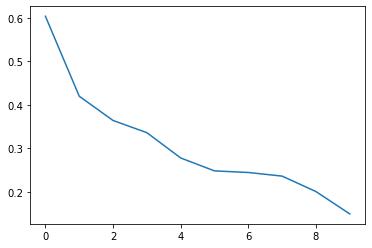

In [56]:
# plot the loss as a function of the number of epochs
plt.plot(loss)


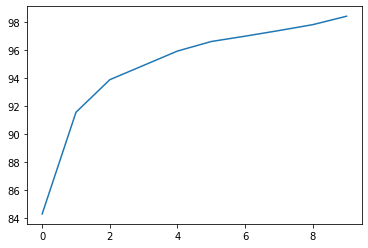

In [57]:
# plot the accuracy as a function of the number of epochs
plt.plot(accuracy)

**Part 2:** Test your neural network on the test set.
Compute the accuracy and the confusion matrix.

In [60]:
X_test=X_test.reshape(len(X_test),1,28,28)

In [61]:
# warning: CNNs on CPUs are very slow. To speed it up, we need to run this on GPUs
n_epochs = 10
loss = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):
    
    # EPOCH = loop over all datapoints
    losses = np.zeros(len(X_test))
    y_test_pred = np.zeros(len(X_test))
    for i in range(len(X_test)):

        # forward pass
        layer1.forward(X_test[i])
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)

        layer3.forward(layer2.output)
        activation3.forward(layer3.output)


        # sample loss
        losses[i] = loss_function.forward(activation3.output,y_test[i].reshape(1))
        # prediction
        y_test_pred[i] = np.argmax(activation3.output,axis=1)

In [62]:
# predictions
y_test_pred[i]

7.0

In [63]:
# accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy=accuracy_score(y_test,y_test_pred)
accuracy

0.9195

In [64]:
# confusion matrix
confusion=confusion_matrix(y_test,y_test_pred)
confusion

array([[187,   0,   8,   0,   1,   1,   5,   1,   1,   1],
       [  0, 216,   5,   1,   0,   0,   0,   0,   2,   0],
       [  0,   0, 176,   3,   2,   0,   1,   1,   2,   0],
       [  0,   2,   8, 179,   0,   2,   0,   2,   1,   1],
       [  0,   2,   3,   1, 189,   0,   4,   3,   1,   1],
       [  0,   0,   0,  10,   0, 166,   7,   0,   2,   0],
       [  0,   0,   1,   0,   0,   1, 190,   0,   2,   0],
       [  0,   0,   1,   4,   3,   1,   0, 196,   2,   3],
       [  1,   5,   3,  11,   0,   1,   7,   0, 152,   3],
       [  0,   2,   0,  10,   7,   1,   0,   6,   1, 188]], dtype=int64)

**Part 3:** Display some of the misclassified digits.

In [65]:
np.where(y_test!=y_test_pred)

(array([  11,   41,   43,   60,   63,   65,   85,  115,  123,  141,  145,
         150,  171,  182,  186,  194,  196,  202,  204,  210,  214,  238,
         240,  243,  248,  250,  255,  260,  264,  272,  300,  311,  339,
         357,  381,  411,  437,  440,  445,  513,  532,  543,  615,  621,
         643,  700,  702,  709,  715,  725,  731,  735,  741,  755,  778,
         779,  799,  800,  851,  861,  865,  870,  883,  911,  943,  954,
         976,  981,  991,  994, 1015, 1024, 1029, 1038, 1073, 1103, 1121,
        1125, 1159, 1161, 1197, 1198, 1201, 1203, 1205, 1209, 1233, 1244,
        1264, 1287, 1291, 1297, 1316, 1321, 1350, 1367, 1369, 1372, 1390,
        1395, 1402, 1405, 1407, 1409, 1413, 1441, 1467, 1481, 1500, 1501,
        1515, 1533, 1535, 1544, 1549, 1556, 1569, 1577, 1585, 1599, 1604,
        1610, 1613, 1614, 1616, 1618, 1623, 1638, 1644, 1646, 1656, 1688,
        1697, 1704, 1707, 1710, 1733, 1736, 1739, 1744, 1748, 1766, 1774,
        1783, 1809, 1828, 1829, 1841, 

7.0 7


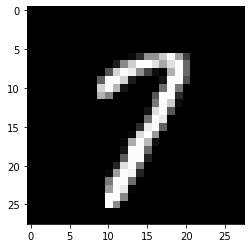

In [66]:
i=130

print(y_test_pred[i],y_test[i])
plt.imshow(X_test[i][0],cmap='gray')

2.0 3


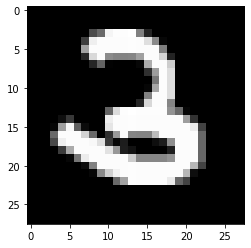

In [67]:
i=41

print(y_test_pred[i],y_test[i])
plt.imshow(X_test[i][0],cmap='gray')

9.0 9


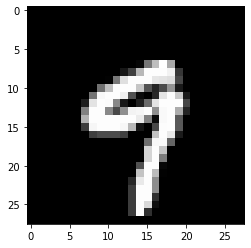

In [68]:
i=22

print(y_test_pred[i],y_test[i])
plt.imshow(X_test[i][0],cmap='gray')